In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("resources/RSCCASN.csv", index_col="DATE", parse_dates=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [9]:
df.describe()

,RSCCASN
count,334.000000
mean,16325.095808
std,5369.839014
min,6938.000000
25%,12298.500000
50%,15878.500000
75%,19772.500000
max,34706.000000


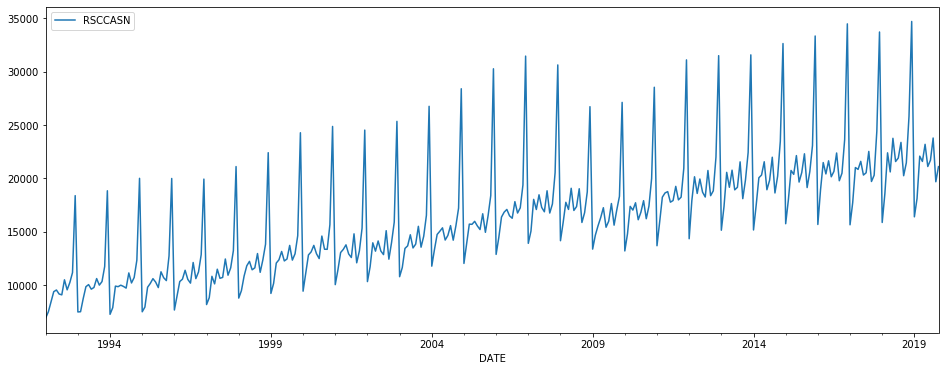

In [11]:
df.plot(figsize = (16,6))

### WE should be forecasting at least a year worth of data 
- The data set displays a obvious annual pattern
- We will use 1.5 years of data 
- 18months 

In [12]:
len(df)

334

In [14]:
test_size = 18

In [15]:
test_index = len(df) - test_size

In [16]:
train = df.iloc[:test_index]

In [17]:
len(train)

316

In [18]:
test = df.iloc[test_index:]

In [19]:
len(test)

18

### Scaling the data 

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scalar = MinMaxScaler()

In [23]:
train_scaled = scalar.fit_transform(train)

In [24]:
test_scaled = scalar.transform(train)

In [25]:
max(train_scaled)

array([1.])

In [26]:
max(test_scaled)

array([1.])

## Creating the Time series Generator
- length of the batch -> since we are adding a validation generator we have to make sure the length of the batch is less than that of the test set
- So lets select 12 months

In [29]:
length = 12 
batch = 1

In [27]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [30]:
generator = TimeseriesGenerator (
    train_scaled,
    train_scaled,
    length = length,
    batch_size= batch,

)

In [31]:
val_gen = TimeseriesGenerator (
    test_scaled,
    test_scaled,
    length = length,
    batch_size= batch,

)

### Looking at the first Batch
- Just to take a look at what is actually happening under the hood

In [37]:
len(generator)

304

In [32]:
X,y = generator[0]

In [33]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [34]:
y

array([[0.02047633]])

In [36]:
train_scaled[12]

array([0.02047633])

#### Creating the model
- We will add a early stopping to prevent overtraining

In [40]:
n_features = 1

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=4)

In [41]:
#model = Sequential()
#model.add(LSTM(units = 12, input_shape = (length, n_features)))
#model.add(Dense(1))
#model.compile(loss = "mse", optimizer = "adam")

In [42]:
#model.fit_generator(generator=generator, validation_data=val_gen, epochs=6, callbacks=[stop])

Epoch 1/6
304/304 [==============================] - 157s 516ms/step - loss: 0.0332 - val_loss: 0.0184
Epoch 2/6
304/304 [==============================] - 169s 555ms/step - loss: 0.0186 - val_loss: 0.0175
Epoch 3/6
304/304 [==============================] - 160s 526ms/step - loss: 0.0178 - val_loss: 0.0161
Epoch 4/6
304/304 [==============================] - 160s 526ms/step - loss: 0.0174 - val_loss: 0.0157
Epoch 5/6
304/304 [==============================] - 167s 550ms/step - loss: 0.0169 - val_loss: 0.0155
Epoch 6/6
304/304 [==============================] - 162s 533ms/step - loss: 0.0160 - val_loss: 0.0147


### Importing Model trained on AWS instance
- for time sake we trained the model on an AWS instance to more epochs 

In [76]:
from tensorflow.keras.models import load_model

In [77]:
retail_model = load_model("resources/retail_final.h5")

In [78]:
model_his = pd.read_csv("resources/model_hist.csv", index_col="Unnamed: 0")

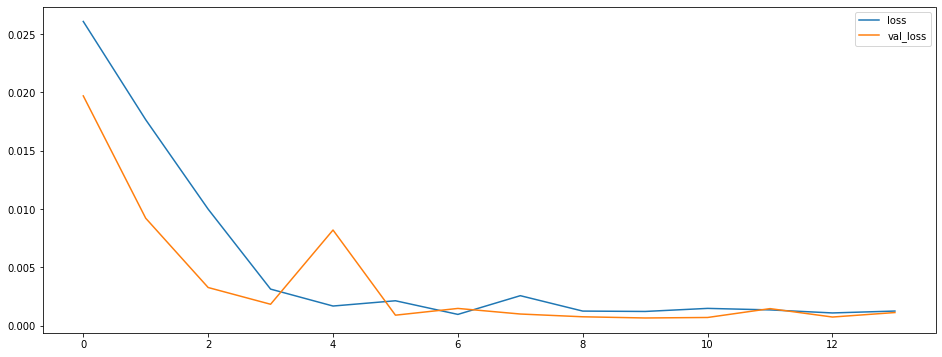

In [79]:
model_his.plot(figsize = (16,6))

In [94]:
test_predictions = []
batch= train_scaled[-length:]
batch_reshaped = batch.reshape(1,length,n_features)
for i in range(len(test)):
    pred = retail_model.predict(batch_reshaped)[0]
    test_predictions.append(pred)
    batch_reshaped = np.append(batch_reshaped[:,1:,:], [[pred]], axis = 1)

In [95]:
test_predictions = scalar.inverse_transform(test_predictions)

In [96]:
test["pred"] = test_predictions

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


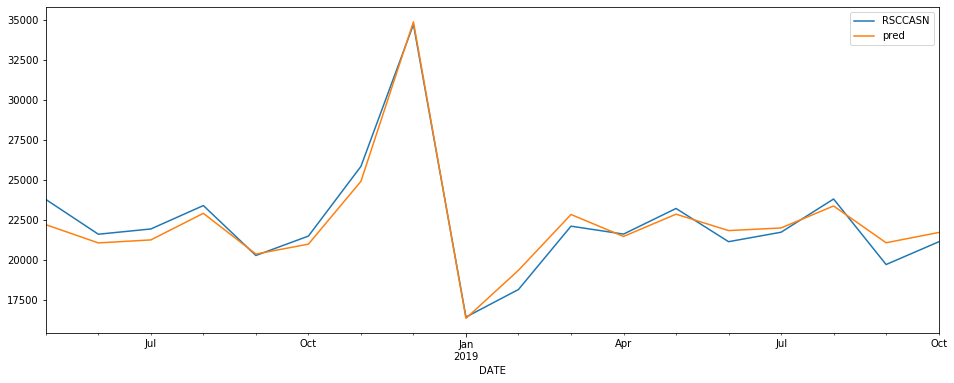

In [97]:
test.plot(figsize = (16,6))

In [132]:
full_scalar = MinMaxScaler()
data_scaled = full_scalar.fit_transform(df)

In [133]:
model = Sequential()
model.add(LSTM(units = 100, activation = "relu", input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(loss = "mse", optimizer = "adam")

In [134]:
data_generator = TimeseriesGenerator(data_scaled,data_scaled, length=12, batch_size=1)

In [135]:
model.fit_generator(data_generator, epochs=16)

Epoch 1/16
322/322 [==============================] - 130s 405ms/step - loss: 0.0260
Epoch 2/16
322/322 [==============================] - 122s 379ms/step - loss: 0.0182
Epoch 3/16
322/322 [==============================] - 133s 412ms/step - loss: 0.0132
Epoch 4/16
322/322 [==============================] - 126s 393ms/step - loss: 0.0070
Epoch 5/16
322/322 [==============================] - 134s 418ms/step - loss: 0.0037
Epoch 6/16
322/322 [==============================] - 128s 398ms/step - loss: 0.0026
Epoch 7/16
322/322 [==============================] - 122s 378ms/step - loss: 0.0025
Epoch 8/16
322/322 [==============================] - 125s 389ms/step - loss: 0.0015
Epoch 9/16
322/322 [==============================] - 123s 383ms/step - loss: 0.0011
Epoch 10/16
322/322 [==============================] - 122s 379ms/step - loss: 0.0014
Epoch 11/16
322/322 [==============================] - 133s 414ms/step - loss: 9.9672e-04
Epoch 12/16
322/322 [==============================] - 117s

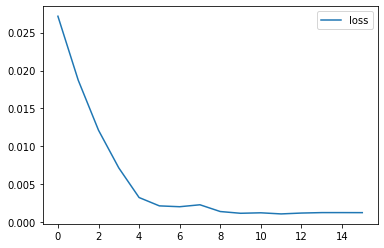

In [121]:
pd.DataFrame(model.history.history).plot()

In [122]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [123]:
model.evaluate_generator(data_generator)

0.0028915600278530593

In [124]:
forecast = []
batch= data_scaled[-length:]
batch_reshaped = batch.reshape(1,length,n_features)
for i in range(length):
    pred = retail_model.predict(batch_reshaped)[0]
    forecast.append(pred)
    batch_reshaped = np.append(batch_reshaped[:,1:,:], [[pred]], axis = 1)


In [128]:
forcast = full_scalar.inverse_transform(forecast)

In [129]:
len(forecast)

12

In [130]:
forecast

[array([0.6978928], dtype=float32),
 array([1.044942], dtype=float32),
 array([0.35214955], dtype=float32),
 array([0.44024637], dtype=float32),
 array([0.56727886], dtype=float32),
 array([0.55750513], dtype=float32),
 array([0.60924804], dtype=float32),
 array([0.54111457], dtype=float32),
 array([0.5615475], dtype=float32),
 array([0.6251285], dtype=float32),
 array([0.49468493], dtype=float32),
 array([0.5420008], dtype=float32)]

In [131]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
